In [125]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size = 32
num_steps = 35
train_iter,vocab = d2l.load_data_time_machine(batch_size,num_steps)

In [126]:
F.one_hot(torch.tensor([0,2]),len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [127]:
def get_params(vocab_size,num_hiddens,device):
    num_input = num_output = vocab_size

    def normal(size):
        return torch.randn(size,device=device)*0.01
    
    Wxh = normal((num_input,num_hiddens))
    Whh = normal((num_hiddens,num_hiddens))
    bh = torch.zeros(num_hiddens,device=device)

    Whq = normal((num_hiddens,num_output))
    bq = torch.zeros(num_output,device=device)

    params = [Wxh,Whh,bh,Whq,bq]
    for param in params:
        param.requires_grad_(True)
    return params

In [128]:
def init_rnn_state(batch_size,num_hidden,device):
    return (torch.zeros((batch_size,num_hidden),device=device),)

In [129]:
def rnn(inputs,state,params):
    Wxh,Whh,bh,Whq,bq=params
    H, = state
    outputs = []

    for input in inputs:
        #print(input.shape,Wxh.shape,H.shape,Whh.shape)
        H = torch.tanh(torch.mm(input,Wxh) + torch.mm(H,Whh) + bh)#激活函数很重要
        outputs.append(torch.mm(H,Whq)+bq)
    return torch.cat(outputs,dim=0),(H,)

In [130]:
class RNNModelScratch:
    def __init__(self,vocab_size,num_hiddens,device,get_params,init_state,forward_fn):
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        self.params = get_params(self.vocab_size,self.num_hiddens,device)
        self.init_state = init_state
        self.forward_fn = forward_fn

    def __call__(self,X,state):
        X = F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forward_fn(X,state,self.params)
    
    def begin_state(self,batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)


In [131]:
num_hiddens = 512
X = torch.arange(10).reshape((2, 5)).to('cuda:0')
net = RNNModelScratch(len(vocab),num_hiddens,device=d2l.try_gpu(),get_params=get_params,init_state=init_rnn_state,forward_fn=rnn)
state = net.begin_state(X.shape[0],d2l.try_gpu())
Y,new_state = net(X,state)
Y.shape,len(new_state),new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [132]:
def predict(prefix,num_preds,net,vocab,device):
    outputs = [vocab[prefix[0]]]
    state = net.begin_state(batch_size=1,device=device)
    get_input = lambda : torch.tensor([outputs[-1]],device=device).reshape(1,1)

    for y in prefix[1:]:#预热
        _,state = net(get_input(),state)
        outputs.append(vocab[y])

    for _ in range(num_preds):
        y,state = net(get_input(),state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))

    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [133]:
predict('time traveler ',10,net,vocab,'cuda:0')

'time traveler suxkhftbl '

In [134]:
def grad_cliped(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    
    norm = torch.sqrt(sum(torch.sum(p.grad**2) for p in params))

    if norm>theta:
        for param in params:
            param.grad[:]*=theta/norm

In [135]:
def train_epoch(train_iter,net,loss,device,updater,use_random_iter):
    state,Timer = None,d2l.Timer()
    metric = d2l.Accumulator(2)
    for X,Y in train_iter:
        if use_random_iter or state is None:
            state = net.begin_state(batch_size=X.shape[0],device=device)
        else:
            if isinstance(net,nn.Module) or not isinstance(state,tuple):
                state = state.detach()
            else:
                for s in state:
                    s.detach_()
        Y = Y.T.reshape(-1)
        X,Y = X.to(device),Y.to(device)
        y_hat,state = net(X,state)
        l =  loss(y_hat,Y.long()).mean()
        if isinstance(net,nn.Module):
            updater.zero_grad()
            l.backward()
            grad_cliped(net,1)
            updater.step()
        else:
            l.backward()
            grad_cliped(net,1)
            updater(batch_size=1)
        metric.add(l*Y.numel(),Y.numel())
    return math.exp(metric[0]/metric[1]),metric[1]/Timer.stop()

In [136]:
def train(net,train_iter,vocab,num_epochs,device,lr=0.1,use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epochs',ylabel='perplexity',legend=['train'],xlim=[10,num_epochs])
    if isinstance(net,nn.Module):
        updater = torch.optim.Adam(net.parameters(),lr)
    else:
        updater = lambda batch_size:d2l.sgd(net.params,lr,batch_size)
    predict_ = lambda prefix:predict(prefix,50,net,vocab,device)
    print(num_epochs)
    for epoch in range(num_epochs):
        ppl,speed = train_epoch(train_iter,net,loss,device,updater,use_random_iter)
        if (epoch+1)%10==0:
            print(predict_('time traveller '))
            animator.add(epoch+1,[ppl])
    print(f"困惑度:{ppl}",f'speed:{speed:.1f}on cuda:0')
    print(predict_('time traveller '))
 

困惑度:1.0161828923527445 speed:92371.0on cuda:0
time traveller for so it will be convenient to speak of himwas ex


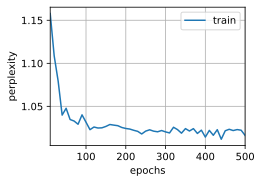

In [143]:
num_epochs=500
lr=1
train(net,train_iter,vocab,num_epochs,'cuda:0',lr=1)

In [150]:
predict('i am the young',50,net,vocab,'cuda:0')

'i am the youngety a four is the exrecomente in any direction of '

困惑度:1.3954909929701533 speed:83738.2on cuda:0
time traveller held in his hand was a glitteringmetallic framewor


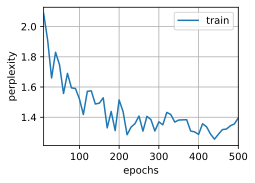

In [145]:
num_epochs=500
lr=1
train(net,train_iter,vocab,num_epochs,'cuda:0',lr=1,use_random_iter=True)